In [1]:
ON_COLAB = True
USE_DRIVE = False

In [2]:
if ON_COLAB:
    # ----- for colab
    !gdown 1TkdWr42pf3BN02xW9diBcldNsC7NYpNd
    !gdown 124jEoZmjnAlXm73RsMBNJZbl6e5F24pR

    from zipfile import ZipFile

    with ZipFile("images.zip", 'r') as zObject:
        zObject.extractall(path="dataset")

    with ZipFile("annotations.zip", 'r') as zObject:
        zObject.extractall(path="dataset")


Downloading...
From (original): https://drive.google.com/uc?id=1TkdWr42pf3BN02xW9diBcldNsC7NYpNd
From (redirected): https://drive.google.com/uc?id=1TkdWr42pf3BN02xW9diBcldNsC7NYpNd&confirm=t&uuid=685791d1-9584-40ac-adc4-e2032fa68066
To: /content/images.zip
100% 792M/792M [00:18<00:00, 41.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=124jEoZmjnAlXm73RsMBNJZbl6e5F24pR
To: /content/annotations.zip
100% 18.1k/18.1k [00:00<00:00, 62.9MB/s]


In [3]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.optim as optim

import matplotlib.pyplot as plt

import math

In [4]:
class OxfordPetDataset(Dataset):
    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        if USE_DRIVE:
            self.root = Path("drive") / "MyDrive" / "Colab Notebooks" / "cv" / "dataset"
        elif ON_COLAB:
            self.root = Path("dataset")
        else:
            self.root = Path("/home/liam/Desktop/magistrale/computervision/progetto/modulo_due/ipcv-assignment-2/dataset")
        self.split = split
        self.names, self.labels = self._get_names_and_labels()
        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img_path = self.root / "images" / f"{self.names[idx]}.jpg"
        img = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

    def _get_names_and_labels(self) -> Tuple[List[str], List[int]]:
        names = []
        labels = []

        with open(self.root / "annotations" / f"{self.split}.txt") as f:
            for line in f:
                name, label = line.replace("\n", "").split(" ")
                names.append(name),
                labels.append(int(label) - 1)

        return names, labels

In [5]:
import random
from torchvision import transforms
from torchvision.transforms import functional as tF

class Random90DegreeRotation:
    """Custom transform for 90-degree rotations with specific probabilities."""
    def __call__(self, img):
        prob = random.random()
        if prob < 0.5:
            return img  # No rotation
        elif prob < 0.75:
            return tF.rotate(img, angle=-90)  # Rotate 90 degrees left
        else:
            return tF.rotate(img, angle=90)  # Rotate 90 degrees right

class OuterRandomCrop:
    """Custom transform to randomly crop the same amount of pixels from each side of the image."""
    def __init__(self, max_pixels_to_crop):
        """
        Args:
            max_pixels_to_crop (int): The maximum number of pixels to subtract from each side of the image.
        """
        self.max_pixels_to_crop = max_pixels_to_crop

    def __call__(self, img):
        # decides whether to apply the crop (75% chance)
        if random.random() < 0.25:
            return img

        # randomly select the number of pixels to crop (between 0 and max_pixels_to_crop)
        pixels_to_crop = random.randint(0, self.max_pixels_to_crop)

        width, height = img.size
        crop_left = pixels_to_crop
        crop_top = pixels_to_crop
        crop_width = width - 2 * pixels_to_crop
        crop_height = height - 2 * pixels_to_crop

        if crop_width <= 0 or crop_height <= 0:
            raise ValueError("The number of pixels to crop is too large for the image dimensions.")

        return tF.crop(img, top=crop_top, left=crop_left, height=crop_height, width=crop_width)


convert_compatible = transforms.Compose([
    transforms.Resize((224, 224)),     # Deterministic resize
    transforms.ToTensor(),             # Format conversion only
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # image net normalization values
])

transform_data_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),       # Random horizontal flip
    OuterRandomCrop(20),                 # Custom outer crop
    Random90DegreeRotation(),                    # Custom 90-degree rotation
    transforms.RandomRotation(10),              # Random rotation of ±10 degrees
    transforms.ColorJitter(brightness=0.4),      # Adjust brightness slightly
    transforms.Resize((224, 224)),
    transforms.ToTensor(),                       # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet stats
                         std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = OxfordPetDataset('train', transform=transform_data_augmentation)
val_dataset = OxfordPetDataset('val', transform=convert_compatible)
test_dataset = OxfordPetDataset('test', transform=convert_compatible)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

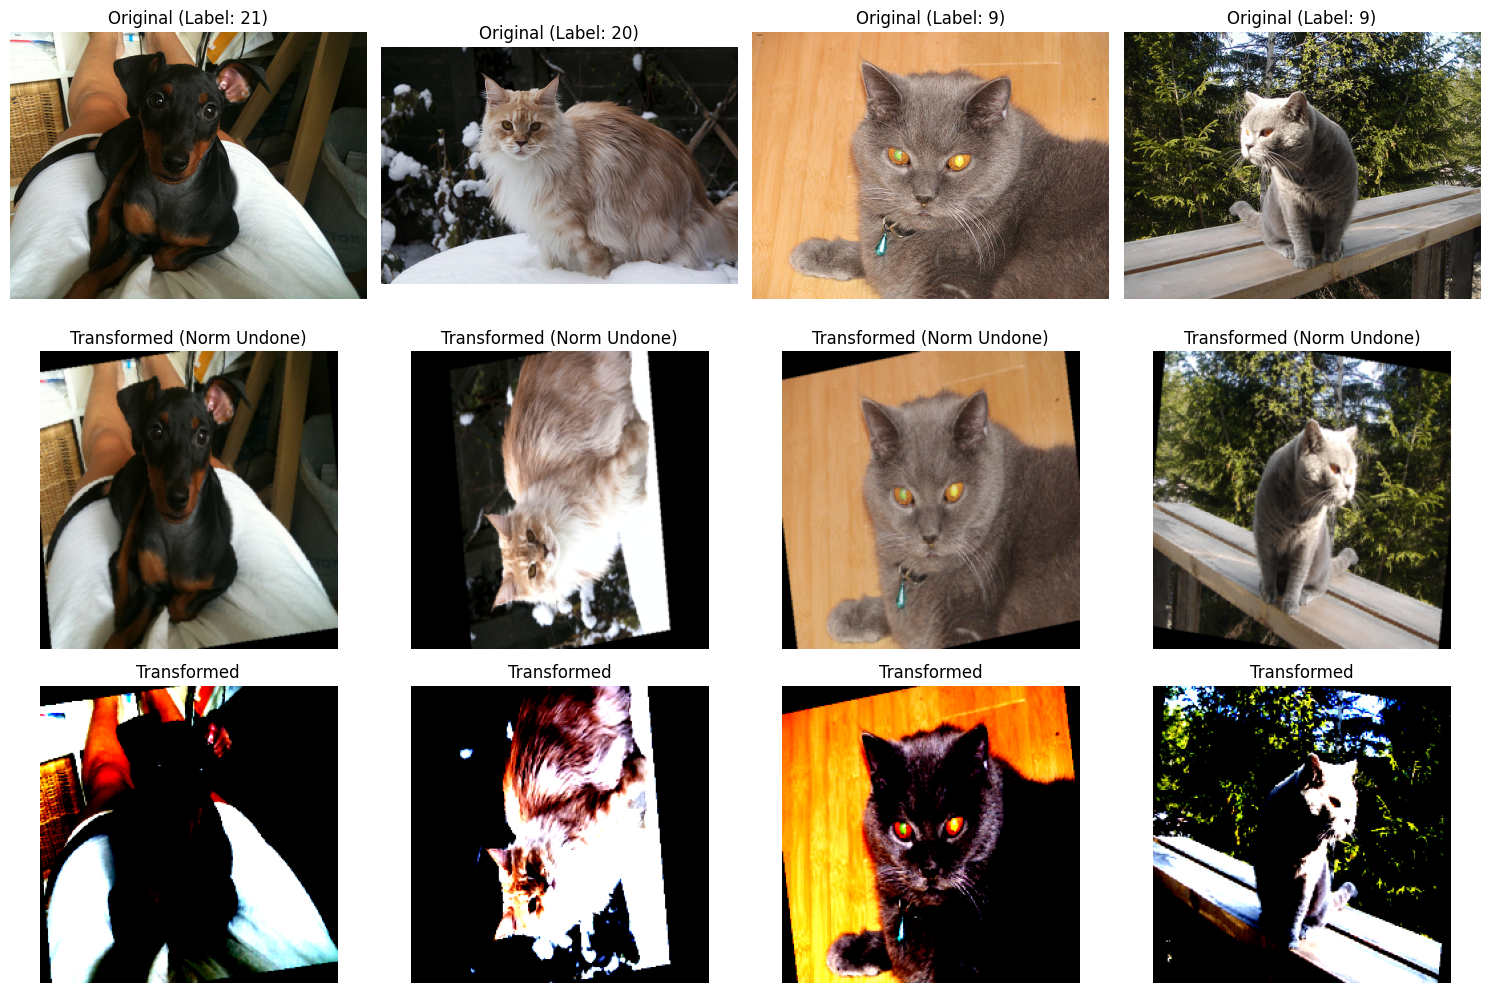

In [ ]:
import matplotlib.pyplot as plt
import random

# Function to display images
# NEW FUNCTION
def display_image_comparison(dataset, num_images=4):
    fig, axes = plt.subplots(3, num_images, figsize=(15, 10))  # 3 rows, num_images columns

    for i in range(num_images):
        # Randomly select an image from the dataset
        idx = random.randint(0, len(dataset) - 1)

        # Access the raw image without applying the dataset's transform
        img_path = dataset.root / "images" / f"{dataset.names[idx]}.jpg"
        original_img = Image.open(img_path).convert("RGB")  # Load as PIL image
        label = dataset.labels[idx]

        # Apply your transformation
        transformed_with_norm = transform_data_augmentation(original_img)  # Fully transformed with normalization

        # Undo normalization for visualization (second row)
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        transformed_with_norm_np = transformed_with_norm.permute(1, 2, 0).numpy()
        transformed_no_norm_np = std * transformed_with_norm_np + mean  # Undo normalization

        # Adjust normalized data for visualization (third row)
        min_val, max_val = transformed_with_norm_np.min(), transformed_with_norm_np.max()
        transformed_visual_np = (transformed_with_norm_np - min_val) / (max_val - min_val)  # Scale to [0, 1]

        # Display original image
        axes[0, i].imshow(original_img)
        axes[0, i].set_title(f"Original (Label: {label})")
        axes[0, i].axis("off")

        # Display transformed image with normalization undone
        axes[1, i].imshow(transformed_no_norm_np)
        axes[1, i].set_title("Transformed (Norm Undone)")
        axes[1, i].axis("off")

        # Display fully transformed image (adjusted for visualization)
        axes[2, i].imshow(transformed_visual_np)
        axes[2, i].set_title("Transformed (Adjusted for Visualization)")
        axes[2, i].axis("off")

    plt.tight_layout()
    plt.show()

# Call the function to display the comparison
display_image_comparison(train_dataset, num_images=4)
print("-"*20)
print("The second row shows image distorsions less the ImageNet normalization, the third row re-normalizes the image in 0-1 range after the ImageNet normalization to show what it looks like")
print("-"*20)


In [7]:
def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=10,
    show_all_minibatches_loss=False,
    lr_scheduler_fn=None  # Function to calculate the next learning rate
):
    """
    Trains a PyTorch model and evaluates it on a validation set.

    Args:
        model (torch.nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for the training dataset.
        val_loader (DataLoader): DataLoader for the validation dataset.
        criterion (torch.nn.Module): Loss function to optimize.
        optimizer (torch.optim.Optimizer): Optimizer for updating model weights.
        num_epochs (int): Number of epochs to train the model.
        show_all_minibatches_loss (bool): Can be 'no', 'brief', 'verbose'. Determines how many mini batch losses are printed
        lr_scheduler_fn (callable, optional): Function to adjust the learning rate based on a metric (validation accuracy).

    Returns:
        tuple: A tuple containing:
            - train_losses (list): List of average training losses per epoch.
            - train_accuracies (list): List of training accuracies per epoch.
            - train_class_accuracies (list): List of per-class training accuracies per epoch.
            - val_losses (list): List of validation losses per epoch.
            - val_accuracies (list): List of validation accuracies per epoch.
            - val_class_accuracies (list): List of per-class validation accuracies per epoch.
    """

    train_losses = []
    train_accuracies = []
    train_class_accuracies = []
    val_losses = []
    val_accuracies = []
    val_class_accuracies = []

    # Get number of classes from the model's output layer
    num_classes = model.fc.out_features

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Initialize per-class counters for training
        train_class_correct = torch.zeros(num_classes, dtype=torch.long)
        train_class_total = torch.zeros(num_classes, dtype=torch.long)

        tot_batches = train_loader.__len__()
        for batch_idx, (batch_images, batch_labels) in enumerate(train_loader):
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)

            # Zero gradients from previous iteration
            optimizer.zero_grad()

            outputs = model(batch_images)
            loss = criterion(outputs, batch_labels)
            if show_all_minibatches_loss != 'no':
                if show_all_minibatches_loss == 'verbose' or batch_idx in [40, 80]:
                    print(f"Batch {batch_idx + 1}/{tot_batches}: loss = {loss.item():.4f}")

            # Compute gradients
            loss.backward()

            # Update weights
            optimizer.step()

            running_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += batch_labels.size(0)
            correct_train += (predicted == batch_labels).sum().item()

            # Per-class accuracy for training
            for i in range(batch_labels.size(0)):
                label = batch_labels[i]
                train_class_total[label] += 1
                if predicted[i] == label:
                    train_class_correct[label] += 1

        train_accuracy = 100 * correct_train / total_train
        train_loss = running_loss / len(train_loader)

        # Calculate per-class accuracies for training
        epoch_train_class_accuracies = []
        for i in range(num_classes):
            if train_class_total[i] > 0:
                class_acc = train_class_correct[i].item() / train_class_total[i].item()
            else:
                class_acc = 0.0  # No samples for this class in training set
            epoch_train_class_accuracies.append(class_acc)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        # Initialize per-class counters for validation
        val_class_correct = torch.zeros(num_classes, dtype=torch.long)
        val_class_total = torch.zeros(num_classes, dtype=torch.long)

        with torch.no_grad():  # Doesn't compute gradients for validation
            for batch_images, batch_labels in val_loader:
                batch_images = batch_images.to(device)
                batch_labels = batch_labels.to(device)

                outputs = model(batch_images)
                loss = criterion(outputs, batch_labels)
                running_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += batch_labels.size(0)
                correct_val += (predicted == batch_labels).sum().item()

                # Per-class accuracy for validation
                for i in range(batch_labels.size(0)):
                    label = batch_labels[i]
                    val_class_total[label] += 1
                    if predicted[i] == label:
                        val_class_correct[label] += 1

        val_accuracy = 100 * correct_val / total_val
        val_loss = running_val_loss / len(val_loader)

        # Calculate per-class accuracies for validation
        epoch_val_class_accuracies = []
        for i in range(num_classes):
            if val_class_total[i] > 0:
                class_acc = val_class_correct[i].item() / val_class_total[i].item()
            else:
                class_acc = 0.0  # No samples for this class in validation set
            epoch_val_class_accuracies.append(class_acc)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        train_class_accuracies.append(epoch_train_class_accuracies)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_class_accuracies.append(epoch_val_class_accuracies)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

        # Adjust learning rate using the scheduler function
        if lr_scheduler_fn is not None:
            new_lr = lr_scheduler_fn(optimizer.param_groups[0]['lr'], val_accuracies)
            for param_group in optimizer.param_groups:
                param_group['lr'] = new_lr # we only modify the learning rate in the optimizer we chose

        print('-'*20)

    return train_losses, train_accuracies, train_class_accuracies, val_losses, val_accuracies, val_class_accuracies



def val_accuracy_scheduler(current_lr, val_accuracies, patience=5, decay_factor=0.5, min_lr=1e-4):
    """
    Adjusts the learning rate based on validation accuracy, with an optional minimum learning rate.

    Args:
        current_lr (float): Current learning rate.
        val_accuracies (list): List of validation accuracies from previous epochs.
        patience (int): Number of epochs to wait for improvement before reducing the learning rate.
        decay_factor (float): Factor by which to reduce the learning rate.
        min_lr (float): Minimum learning rate allowed.

    Returns:
        float: New learning rate.
    """
    if len(val_accuracies) > patience:
        recent_accuracies = val_accuracies[-patience:]
        previous_max = max(val_accuracies[-(patience + 1):])
        if max(recent_accuracies) + (previous_max / 200) <= previous_max:
            new_lr = max(current_lr * decay_factor, min_lr)  # Ensure lr doesn't go below min_lr
            print(f"Learning rate adjusted to: {new_lr}")
            return new_lr
    return current_lr



def generate_cosine_cycle(T_max, lr_max, lr_min):
    """
    Generates an array of learning rate values for a complete cosine annealing cycle.

    Args:
        T_max (int): Number of iterations to complete one cycle.
        lr_max (float): Maximum learning rate.
        lr_min (float): Minimum learning rate.

    Returns:
        list: Array of learning rate values for the cycle.
    """
    cycle = [
        lr_min + (lr_max - lr_min) * (1 + math.cos(math.pi * t / T_max)) / 2
        for t in range(T_max)
    ]
    # Append the reverse of the cycle to complete the up-down pattern
    return cycle + cycle[::-1][1:-1]  # Avoid duplicating the peak value
'''
print(generate_cosine_cycle(4, 0.001, 0.00005))
[0.001, 0.0008608757210636101, 0.000525, 0.00018912427893638995, 0.000525, 0.0008608757210636101]
'''
def adaptive_cosine_scheduler(current_lr, val_accuracies, patience=5, lr_cycle=[0.001, 0.0008608757210636101, 0.000525, 0.00018912427893638995, 0.000525, 0.0008608757210636101]):
    """
    Adjusts the learning rate using a cosine annealing cycle and a patience mechanism based on validation accuracy.

    Args:
        current_lr (float): Current learning rate.
        val_accuracies (list): List of validation accuracies from previous epochs.
        lr_cycle (list, optional): Precomputed array of learning rate values for the cycle.
        patience (int, optional): Number of epochs to wait for improvement before advancing in the cycle. Default is 5.

    Returns:
        float: New learning rate.
    """
    if lr_cycle is None:
        raise ValueError("lr_cycle must be provided as a precomputed array of learning rate values.")

    # Deduce the current index in the cycle based on the current learning rate
    try:
        current_index = lr_cycle.index(current_lr)
    except ValueError:
        raise ValueError("current_lr is not in the provided lr_cycle. Ensure the cycle matches the training setup. Current cycle: ", lr_cycle)

    # Check if validation accuracy has stalled
    if len(val_accuracies) > patience:
        recent_accuracies = val_accuracies[-patience:]
        previous_max = max(val_accuracies[-(patience + 1):])
        if max(recent_accuracies) + (previous_max / 200) <= previous_max:
            # Advance to the next position in the cycle
            next_index = (current_index + 1) % len(lr_cycle)
            new_lr = lr_cycle[next_index]
            print(f"Validation accuracy has stalled. Advancing in the cycle. Setting LR to {new_lr:.6f}, Cycle Index: {next_index}/4") #this 4 is the T_max in the generate_cosine_cycle function. if you change the cycle change also this print value
            return new_lr

    # If accuracy has not stalled, keep the current learning rate
    return current_lr



# resnet model

è una resnet con blocchi fpn con pochi canali,

sempre senza SE, ho cambiato lo scheduler. ora è ciclico

segue un ciclo cosenico precacalcolato di 4 passi dal massimo al minimo, lo scheduler viene aggiornato quando la val acc stalla, stesso criterio dello scheduler vecchio a riduzione lineare

In [ ]:
class BasicBlock(nn.Module):
    """A basic residual block for ResNet."""
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    """Custom ResNet architecture."""
    def __init__(self, block, layers, in_channels=8, num_classes=37):
        super(ResNet, self).__init__()
        self.in_channels = in_channels

        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual layers
        self.layer1 = self._make_layer(block, in_channels, layers[0])
        self.layer2 = self._make_layer(block, in_channels * 2, layers[1], stride=2)
        self.layer3 = self._make_layer(block, in_channels * 4, layers[2], stride=2)
        self.layer4 = self._make_layer(block, in_channels * 8, layers[3], stride=2)

        # Fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(in_channels * 8, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def resnet18_fpn(num_classes=37):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)



num_classes = 37
model_resnet_fpn = resnet18_fpn(num_classes=num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_resnet_fpn = model_resnet_fpn.to(device)


from torchsummary import summary
summary(model_resnet_fpn, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 112, 112]           1,176
       BatchNorm2d-2          [-1, 8, 112, 112]              16
              ReLU-3          [-1, 8, 112, 112]               0
         MaxPool2d-4            [-1, 8, 56, 56]               0
            Conv2d-5            [-1, 8, 56, 56]             576
       BatchNorm2d-6            [-1, 8, 56, 56]              16
              ReLU-7            [-1, 8, 56, 56]               0
            Conv2d-8            [-1, 8, 56, 56]             576
       BatchNorm2d-9            [-1, 8, 56, 56]              16
             ReLU-10            [-1, 8, 56, 56]               0
       BasicBlock-11            [-1, 8, 56, 56]               0
           Conv2d-12            [-1, 8, 56, 56]             576
      BatchNorm2d-13            [-1, 8, 56, 56]              16
             ReLU-14            [-1, 8,

In [9]:
#model_resnet_fpn = resnet18_fpn.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet_fpn.parameters(), lr=0.001)

train_losses, train_accuracies, train_class_accuracies, val_losses, val_accuracies, val_class_accuracies = train_model(
    model_resnet_fpn, train_loader, val_loader, criterion, optimizer, num_epochs=70, show_all_minibatches_loss='no', lr_scheduler_fn=adaptive_cosine_scheduler
)

Epoch [1/70], Train Loss: 3.5618, Train Acc: 3.92%, Val Loss: 3.5227, Val Acc: 6.22%
--------------------
Epoch [2/70], Train Loss: 3.4461, Train Acc: 6.68%, Val Loss: 3.5182, Val Acc: 5.23%
--------------------
Epoch [3/70], Train Loss: 3.4139, Train Acc: 6.62%, Val Loss: 3.3869, Val Acc: 6.65%
--------------------
Epoch [4/70], Train Loss: 3.3424, Train Acc: 8.45%, Val Loss: 3.4493, Val Acc: 7.58%
--------------------
Epoch [5/70], Train Loss: 3.2623, Train Acc: 9.65%, Val Loss: 3.3752, Val Acc: 9.16%
--------------------
Epoch [6/70], Train Loss: 3.1922, Train Acc: 10.79%, Val Loss: 3.3356, Val Acc: 8.89%
--------------------
Epoch [7/70], Train Loss: 3.1139, Train Acc: 13.27%, Val Loss: 3.2537, Val Acc: 10.91%
--------------------
Epoch [8/70], Train Loss: 3.0339, Train Acc: 14.72%, Val Loss: 3.1404, Val Acc: 11.94%
--------------------
Epoch [9/70], Train Loss: 2.9915, Train Acc: 16.49%, Val Loss: 3.4425, Val Acc: 9.38%
--------------------
Epoch [10/70], Train Loss: 2.9353, Train

In [10]:
import os
import pickle



output_dir = "results"

os.makedirs(output_dir, exist_ok=True)

# Save training losses
with open(os.path.join(output_dir, "train_losses_fpn_se_3_cos_cycle_200k.pkl"), "wb") as f:
    pickle.dump(train_losses, f)

with open(os.path.join(output_dir, "train_accuracies_fpn_se_3_cos_cycle_200k.pkl"), "wb") as f:
    pickle.dump(train_accuracies, f)

with open(os.path.join(output_dir, "train_class_accuracies_fpn_se_3_cos_cycle_200k.pkl"), "wb") as f:
    pickle.dump(train_class_accuracies, f)

with open(os.path.join(output_dir, "val_losses_fpn_se_3_cos_cycle_200k.pkl"), "wb") as f:
    pickle.dump(val_losses, f)

with open(os.path.join(output_dir, "val_accuracies_fpn_se_3_cos_cycle_200k.pkl"), "wb") as f:
    pickle.dump(val_accuracies, f)

with open(os.path.join(output_dir, "val_class_accuracies_fpn_se_3_cos_cycle_200k.pkl"), "wb") as f:
    pickle.dump(val_class_accuracies, f)

torch.save(model_resnet_fpn, "resnet_18_700k_fpn_se__3_cos_cycle_200k_training_weights")

# Test set accuracy

In [11]:
# Load the saved model weights and map them to the CPU
# model_resnet.load_state_dict(torch.load("resnet_18_complete_training_weights", map_location=torch.device('cpu')))
# model_resnet = model_resnet.to(device)  # Move the model to the appropriate device (CPU or GPU)

# Set the model to evaluation mode
model_resnet_fpn.eval()

# Initialize variables to track correct predictions and total samples
correct = 0
total = 0

# Disable gradient computation for evaluation
with torch.no_grad():
    for batch_images, batch_labels in test_loader:
        # Move data to the same device as the model
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)

        # Forward pass: get predictions
        outputs = model_resnet_fpn(batch_images)
        _, predicted = torch.max(outputs.data, 1)

        # Update total and correct counts
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

# Calculate and print the accuracy
test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 43.39%


In [12]:
from torchviz import make_dot
from torchsummary import summary
from IPython.display import Image as IpImage

# given model and a file path, saves the image of the architecture of the model
# if successful returns the file path, otherwise returns None
def generate_architecture_image(model, filepath):
    try :
        dummy_input = torch.randn(1, 3, 224, 224).to(device)
        output = model(dummy_input) # pass the dummy input through the model

        make_dot(
            output, params=dict(model.named_parameters())) \
            .render(filepath, format="png"
        )
    except:
        return None

    return filepath

ModuleNotFoundError: No module named 'torchviz'